In [19]:
import numpy as np
import pandas as pd
import re

/Users/boralim/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
data = pd.read_csv('/Users/boralim/Desktop/capstone/crawling_naver_iphone.csv', encoding='utf-8')
#column name: description
description = list(data.description)

In [3]:
#구두점 및 특수문자 제거
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

#한글, 영문, 숫자만 남기고 제거
def clean_text(text): 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip()
    text = text.replace("b", " ").strip()
    text = re.sub('[^ㄱ-ㅣ가-힣|0-9|a-zA-Z]+', repl=' ', string=text) 
    return text

In [4]:
clean_description=[]
for sentance in description:
    result = strip_punctuation(sentance)
    result = clean_text(result)
    clean_description.append(result)

In [5]:
#의미 없는 단어 제거
no_keyword=['아이폰12', '아이폰11', '아이폰 12', '아이폰 11', '12', '11', 'iPhone12']

In [7]:
from konlpy.tag import Kkma
kkma = Kkma() #형태소 분석기

dataset=[]
for i in range(len(clean_description)):
    dataset.append(kkma.nouns(re.sub('[^가-힣|0-9|a-zA-Z]+', '', clean_description[i])))

In [8]:
#불용어 제거
stopwords_file = open("한국어불용어100.txt", "r")
stop_words = []
for line in stopwords_file.readlines():
    stop_words.append(line)
stopwords_file.close()

dataset_without_stopwords=[]
for w in dataset:
    if w not in stop_words:
        dataset_without_stopwords.append(w)

In [35]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

In [10]:
#데이터를 dictionary 형태로 명사 리스트 만들기
dataset2=dataset_without_stopwords
dataset2=[[y for y in x if not len(y)==1] for x in dataset2]

#정수 인코딩과 빈도수 생성
dictionary=corpora.Dictionary(dataset2)

#출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus=[dictionary.doc2bow(text) for text in dataset2]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 232
Number of documents: 1000


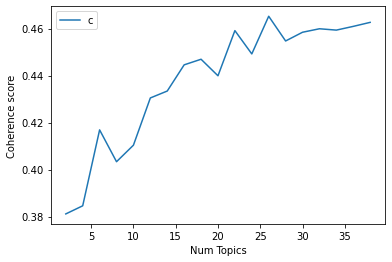

In [11]:
# 최적의 토픽 수 찾기 
#CoherenceModel을 통한 토픽 최적화: 토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step): 
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values

def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40; 
    start = 2; 
    step = 2; 
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.show()

find_optimal_number_of_topics(dictionary, corpus, dataset2)

In [68]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=6, alpha=0.1, id2word=dictionary)

topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.023*"느낌" + 0.019*"이유" + 0.014*"그래파이트" + 0.014*"화이트" + 0.013*"예약" + 0.012*"생각" + 0.012*"사전" + 0.012*"아이폰12시리즈" + 0.012*"제가" + 0.012*"블랙"')
(1, '0.024*"기존" + 0.016*"하나" + 0.015*"부착" + 0.014*"용량" + 0.014*"정도" + 0.013*"범퍼" + 0.013*"부분" + 0.013*"데이터" + 0.013*"제공" + 0.011*"이상"')
(2, '0.020*"크기" + 0.020*"10" + 0.019*"아이폰11" + 0.019*"처음" + 0.016*"비교" + 0.016*"사이즈" + 0.015*"차이" + 0.013*"럭시" + 0.013*"무게" + 0.013*"기본"')
(3, '0.018*"때문" + 0.017*"화이트" + 0.017*"12시리즈" + 0.017*"제가" + 0.017*"시간" + 0.015*"정도" + 0.015*"휴대폰" + 0.015*"선택" + 0.015*"부분" + 0.013*"생각"')
(4, '0.028*"강화" + 0.024*"강화유리" + 0.018*"하세" + 0.017*"주문" + 0.017*"안녕" + 0.016*"12프로" + 0.016*"안녕하세" + 0.016*"폰케이스" + 0.016*"기존" + 0.016*"그립"')
(5, '0.024*"경우" + 0.022*"충전" + 0.019*"컬러" + 0.018*"세이프" + 0.017*"카드" + 0.016*"후기" + 0.013*"충전기" + 0.013*"탑재" + 0.013*"때문" + 0.013*"스펙"')


In [69]:
# Compute Coherence Score using c_v 0.55정도가 준수
coherence_model_lda = CoherenceModel(model=ldamodel, texts=dataset2, dictionary=dictionary, coherence='c_v') 
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score (c_v): ', coherence_lda) 

# Compute Coherence Score using UMass 0에 가까울수록 완벽한 일관성
coherence_model_lda = CoherenceModel(model=ldamodel, texts=dataset2, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score (u_mass): ', coherence_lda)


Coherence Score (c_v):  0.38658410354535694

Coherence Score (u_mass):  -11.056233055352171


In [70]:
#LDA 토픽모델링 시각화 결과 출력: Intertopic Distance Map이 겹치지 않고 잘 구분되어야 적절한 토픽개수로 볼 수 있음
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.047688 -0.073628       1        1  20.113367
5      0.031074  0.093734       2        1  17.434573
2      0.076112 -0.001329       3        1  16.556816
0     -0.049209  0.019517       4        1  16.122880
1     -0.028570 -0.026629       5        1  15.485937
3     -0.077095 -0.011665       6        1  14.286427, topic_info=         Term       Freq      Total Category  logprob  loglift
95         기본  19.000000  19.000000  Default  30.0000  30.0000
200        이유  19.000000  19.000000  Default  29.0000  29.0000
130       화이트  31.000000  31.000000  Default  28.0000  28.0000
181        부분  27.000000  27.000000  Default  27.0000  27.0000
125        카드  22.000000  22.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
19         스펙   5.973484  34.339608   Topic6  -4.6820   0.1969
59         사전   5.794057  33.530108   Topic6  -4.7125   0.1902
159  케이스아이폰12   5.973683  38.541948   Topic6  -4.6819   0.0815
75         가능   5.740110  32.415330   Topic6  -4.7218   0.2147
60         예약   5.774764  34.505732   Topic6  -4.7158   0.1582

[301 rows x 6 columns], token_table=      Topic      Freq Term
term                      
231       1  0.418802   03
231       2  0.069800   03
231       3  0.069800   03
231       4  0.139601   03
231       5  0.069800   03
...     ...       ...  ...
106       2  0.159118  휴대폰
106       3  0.063647  휴대폰
106       4  0.127294  휴대폰
106       5  0.127294  휴대폰
106       6  0.318236  휴대폰

[918 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 1, 2, 4])

In [71]:
#데이터 다시 불러오기
data = pd.read_csv('/Users/boralim/Desktop/capstone/crawling_naver_iphone.csv', encoding='utf-8')
#column name: description
description = list(data.description)

#데이터 샘플
print(description[10])

In [89]:
#문서별 토픽 분포 보기
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [101]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['Document_No', 'Dominant_Topic', 'Dominant_Percent', 'All_Percent']

In [102]:
topictable

,Document_No,Dominant_Topic,Dominant_Percent,All_Percent
0,0,3.0,0.8611,"[(0, 0.027783247), (1, 0.027780933), (2, 0.027..."
1,1,3.0,0.9242,"[(0, 0.015154712), (1, 0.0151545685), (2, 0.01..."
2,2,2.0,0.6977,"[(2, 0.6977114), (5, 0.26453882)]"
3,3,2.0,0.8611,"[(0, 0.027780022), (1, 0.02778278), (2, 0.8610..."
4,4,3.0,0.8611,"[(0, 0.027785325), (1, 0.027785938), (2, 0.027..."
...,...,...,...,...
995,995,5.0,0.4748,"[(0, 0.021742076), (1, 0.021741882), (2, 0.021..."
996,996,3.0,0.7033,"[(0, 0.22526002), (1, 0.017860893), (2, 0.0178..."
997,997,2.0,0.9418,"[(0, 0.011628897), (1, 0.011630584), (2, 0.941..."
998,998,0.0,0.8913,"[(0, 0.89128244), (1, 0.021744305), (2, 0.0217..."


In [113]:
#add original text to the end of the output
topictable_original = pd.concat([topictable, data['description']], axis=1)

In [114]:
topictable_original

,Document_No,Dominant_Topic,Dominant_Percent,All_Percent,description
0,0,3.0,0.8611,"[(0, 0.027783247), (1, 0.027780933), (2, 0.027...",애플의 첫 5G폰 iPhone 12 시리즈 중에서 <b>아이폰12</b> PRO는 ...
1,1,3.0,0.9242,"[(0, 0.015154712), (1, 0.0151545685), (2, 0.01...",iPhone 12 퍼플 리뷰 부제 : 내가 보려고 기록해 놓는 ••• 갑작스럽게 폰...
2,2,2.0,0.6977,"[(2, 0.6977114), (5, 0.26453882)]",애플은 매년 9월 아이폰 신제품을 공개합니다. 작년의 경우 코로나 19로 인해 9월...
3,3,2.0,0.8611,"[(0, 0.027780022), (1, 0.02778278), (2, 0.8610...",이런 관점에서 아이폰 11 Pro Max와 12Pro Max 두 모델의 스펙을 비교...
4,4,3.0,0.8611,"[(0, 0.027785325), (1, 0.027785938), (2, 0.027...",얼른 시간이 가길 바라는 마음으로 <b>아이폰12</b>를 구매하고자 하는 분들이 ...
...,...,...,...,...,...
995,995,5.0,0.4748,"[(0, 0.021742076), (1, 0.021741882), (2, 0.021...",영상 속 <b>아이폰 12</b> 부품들은 전작 아이폰 11과 외관만큼이나 완전히 ...
996,996,3.0,0.7033,"[(0, 0.22526002), (1, 0.017860893), (2, 0.0178...",<b>아이폰 12</b> pro의 그래파이트 색상은 사랑입니다 &lt;3 아이폰 1...
997,997,2.0,0.9418,"[(0, 0.011628897), (1, 0.011630584), (2, 0.941...",4형(대각선) 전면 화면 OLED 디스플레이 2340 x 1080 픽셀 해상도(47...
998,998,0.0,0.8913,"[(0, 0.89128244), (1, 0.021744305), (2, 0.0217...",많지만 아이폰 자체만으로 너무 이뻐서 투명한게 좋겠다 싶어 선택하게 된 ESR<b>...


In [119]:
topictable_original.dtypes

Document_No           int64
Dominant_Topic      float64
Dominant_Percent    float64
All_Percent          object
description          object
dtype: object

In [121]:
pd.set_option('mode.chained_assignment',  None)

In [122]:
#토픽별 문장 분류해서 저장하기
for i in range(0,6):
    globals()['df_{}'.format(i)]=topictable_original.loc[topictable.Dominant_Topic==i]
    globals()['df_{}'.format(i)].sort_values('Dominant_Percent',ascending=False,inplace = True)
    globals()['df_{}'.format(i)].to_csv("./topic("+str(i)+")_review.csv", index = None)

In [ ]:
for i in range(0, 6):
    data = pd.read_csv('/Users/boralim/Desktop/capstone/crawling_naver_iphone.csv', encoding='utf-8')

In [133]:
#토픽 별 불러와서 감성분석 실시해보기 
topic1_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(0)_review.csv', encoding='utf-8').description)
topic2_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(1)_review.csv', encoding='utf-8').description)
topic3_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(2)_review.csv', encoding='utf-8').description)
topic4_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(3)_review.csv', encoding='utf-8').description)
topic5_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(4)_review.csv', encoding='utf-8').description)
topic6_data = list(pd.read_csv('/Users/boralim/Desktop/capstone/topic(5)_review.csv', encoding='utf-8').description)

In [137]:
print("number of sentence of topic 1: ", len(topic1_data))
print("number of sentence of topic 2: ", len(topic2_data))
print("number of sentence of topic 3: ", len(topic3_data))
print("number of sentence of topic 4: ", len(topic4_data))
print("number of sentence of topic 5: ", len(topic5_data))
print("number of sentence of topic 6: ", len(topic6_data))

number of sentence of topic 1:  192
number of sentence of topic 2:  145
number of sentence of topic 3:  150
number of sentence of topic 4:  143
number of sentence of topic 5:  205
number of sentence of topic 6:  165


In [138]:
#감성사전 불러오기
#우선 KOSAC(Korean Sentiment Analysis Corpus) 코드로 감성 분석 해본다.
f = open("lexicon/polarity.csv", encoding="utf-8")
for line in f.read().split("\n")[:10]:
    line = line.strip().split(",")
    print(line)
f.close()

['ngram', 'freq', 'COMP', 'NEG', 'NEUT', 'None', 'POS', 'max.value', 'max.prop']
['가*/JKS', '1', '0', '0', '0', '0', '1', 'POS', '1']
['가*/JKS;있/VV', '1', '0', '0', '0', '0', '1', 'POS', '1']
['가*/JKS;있/VV;었/EP', '1', '0', '0', '0', '0', '1', 'POS', '1']
['가*/VV', '3', '0', '0', '0', '0', '1', 'POS', '1']
['가*/VV;ㄴ다*/EF', '1', '0', '0', '0', '0', '1', 'POS', '1']
['가/JKC', '17', '0', '0.470588235', '0.235294118', '0', '0.294117647', 'NEG', '0.470588235']
['가/JKC;되/VV', '11', '0', '0.363636364', '0.272727273', '0', '0.363636364', 'NEG', '0.363636364']
['가/JKC;되/VV;ㄴ/ETM', '2', '0', '0', '1', '0', '0', 'NEUT', '1']
['가/JKC;되/VV;ㄹ/ETM', '1', '0', '0', '1', '0', '0', 'NEUT', '1']


In [139]:
#KOSAC 감성사전을 딕셔너리에 저장
sentiment = {}

f = open("lexicon/polarity.csv", encoding="utf-8")
for line in f:
    col = line.strip().split(",")
    pos = col[0]
    polarity = col[7]
    score = col[8]
    # 극성이 POS인 경우 +, NEG인 경우 -를 곱해 스코어(score)를 계산합니다.
    if polarity == "POS":
        score = float(score)
    elif polarity == "NEG":
        score = -float(score)
    else:
        # 긍정 또는 부정인 경우만 취급합니다.
        continue
    # 세미콜론(;)을 띄어쓰기로 바꿔 딕셔너리에 스코어와 함께 저장합니다.
    sentiment[pos.replace(";", " ")] = score

f.close()

# 생성한 감성사전 딕셔너리 샘플을 출력합니다.

# 긍정
#print("(긍정) 솜씨/NNG 는/JX 능숙/XR :", sentiment["솜씨/NNG 는/JX 능숙/XR"])
#print("(긍정) 자연/NNG 스럽/XSA :", sentiment["자연/NNG 스럽/XSA"])
# 부정
#print("(부정) 에서/JKB 욕/NNG 튀어나오/VV :", sentiment["에서/JKB 욕/NNG 튀어나오/VV"])
#print("(부정) 유달리/MAG 난해/XR :", sentiment["유달리/MAG 난해/XR"])

In [140]:
#문장을 형태소 단위로 분리하기 샘플
print(kkma.pos(topic1_data[10]))

[('영롱', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETD'), ('<', 'SS'), ('b', 'OL'), ('>', 'SS'), ('아이', 'NNG'), ('폰', 'NNG'), ('12', 'NR'), ('<', 'SS'), ('/', 'SP'), ('b', 'OL'), ('>', 'SS'), ('프로', 'NNG'), ('그래파이트', 'NNG'), ('!', 'SF'), ('이번', 'NNG'), ('에', 'JKM'), ('도', 'JX'), ('아이', 'NNG'), ('폰', 'NNG'), ('x', 'OL'), ('와', 'JKM'), ('동일', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('256', 'NR'), ('기가', 'NNG'), ('로', 'JKM'), ('선택', 'NNG'), ('하', 'XSV'), ('었', 'EPT'), ('어요', 'EFN'), ('.', 'SF'), ('카메라', 'NNG'), ('렌즈', 'NNG'), ('가', 'JKS'), ('하나', 'NR'), ('더', 'MAG'), ('늘', 'VV'), ('어서', 'ECD'), ('그렇', 'VA'), ('ㄴ지', 'ECD'), ('확실히', 'MAG'), ('사진', 'NNG'), (',', 'SP'), ('동영상', 'NNG'), ('이', 'JKS'), ('다르', 'VA'), ('더', 'EPT'), ('라고요', 'EFN'), ('.', 'SF'), ('그리하', 'VV'), ('여', 'ECD'), ('선지', 'NNG'), ('요즘', 'NNG'), ('사진', 'NNG'), ('찍', 'VV'), ('는', 'ETD'), ('재미', 'NNG'), ('가', 'JKS'), ('쏠쏠', 'XR'), ('하', 'XSA'), ('고요', 'EFN'), ('?', 'SF'), ('...', 'SE')]


In [153]:
def sentimental_analysis(data_ls):
    #형태소 분석
    tag_data=[]

    now = 0
    for desc in data_ls:
        now += 1
        print(now, end="\r") #오.. 진행상황을 카운트다운처럼 프린트로 찍어주는 코드!
        tag_list = kkma.pos(desc)
        tag_desc = []
        for word, pos in tag_list:
            tag_desc.append(word + "/" + pos)
        tag_data.append(tag_desc)
    
    # 감성분석 결과를 긍정과 부정 리뷰로 각각 저장할 리스트를 생성합니다.
    positive_sentence = []
    negative_sentence = []

    for tag_sentence, review in zip(tag_data, data_ls):
        # 스코어를 0점으로 초기화합니다.
        score = 0.0
        # 형태소분석된 문장 안에서 최대 7개까지 결합된 형태소가 감성사전 안에 있는지 확인합니다.
        for i in range(len(tag_sentence)):
            max_n = 7
            for n in range(max_n):
                ngram = ""
                for j in range(len(tag_sentence)-n):
                    ngram += " " + tag_sentence[j]
                ngram = ngram.strip()
                if ngram in sentiment.keys():
                    score += sentiment[ngram]
        # 감성스코어로 긍정 또는 부정을 판단하기위한 임계값을 지정합니다.
        limit = 0
        if score > limit:
            positive_sentence.append(["POSITIVE", str(review)])
        elif score < -limit:
            negative_sentence.append(["NEGATIVE", str(review)])

    # 감성분석 결과를 감성스코어를 기준으로 정렬합니다.
    positive_sentence.sort(reverse=True)
    negative_sentence.sort()
    
    print("긍정판별 문장 개수 :", len(positive_sentence))
    positive_sentence[:10]
    print("부정판별 문장 개수 :", len(negative_sentence))
    negative_sentence[:10]
    print("\r")

In [154]:
i=1
for data_ls in [topic1_data, topic2_data, topic3_data, topic4_data, topic5_data, topic6_data]:
    print(i, "번째 토픽 감성분석 결과: ")
    sentimental_analysis(data_ls)
    i=i+1

1 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

2 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

3 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

4 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

5 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

6 번째 토픽 감성분석 결과: 
긍정판별 문장 개수 : 0
부정판별 문장 개수 : 0

